## <span style="color:blue"> SolarEdge Data </span>

#### <b style="color:blue;"> Site Energy / Power Measurements </b>

SolarEdge API Handbook: https://www.solaredge.com/sites/default/files/se_monitoring_api.pdf

Potential APIs:

**Site Energy** Site energy measurements <br>
**Site Energy – Time Period** Site energy for a requested timeframe <br>
**Site Power** Site power measurements in a 15-minute resolution <br>
**Site Overview** Site current power, energy production (today, this month, lifetime) and lifetime revenue <br>
**Site Power** Detailed site power measurements including meters such as consumption, export (feed-in), import (purchase), etc. <br>
**Site Energy** Detailed site energy measurements including meters such as consumption<br>
**Site Power** Flow Get the power flowchart of the site <br>
**Site Image** The site image as uploaded to the server, either scaled or original size <br>
**Site Environmental Benefits** Summary of site’s positive impact on the environment <br>
**Inverter Technical Data** Technical data on the inverter performance for a requested period of time <br>
**Account List API** The account details and list of all sub-accounts <br>
**Get Sensor List** The list of sensors installed in the site <br>
**Get Sensor Data** The measurements of the sensors installed in the site <br>
**Get Meters Data** Information about each meter in the site including: lifetime energy, metadata and the device to which it’s connected to. <br>
**API Versions** The current and supported version numbers<br>

| **Commands**                | **Description**                                  |   | **Commands**           | **Description**                                |
|-----------------------------|--------------------------------------------------|---|------------------------|------------------------------------------------|
| accounts                    | Get the accessible   >sub< accounts.             |   | site_inventory         | Inventory of SolarEdge equipment at the   site |
| site_current_power_flow     | Current power flow between all elements   of...  |   | site_meters            | Meter lifetime energy, metadata and...         |
| site_data_period            | Sites(s) start_date and end_date of...           |   | site_overview          | Sites(s) overview data                         |
| site_details                | Get site details; name, location,   status,...   |   | site_power             | Site(s) power measurements                     |
| site_energy                 | Site(s) energy measurements                      |   | site_power_details     | Detailed site power measurements from   meters |
| site_energy_details         | Detailed site energy measurements from   meters  |   | site_storage_data      | Detailed storage information from   batteries  |
| site_environmental_benefits | Environmental benefits based on site   energy... |   | site_time_frame_energy | Site(s) total energy produced for a   given... |
| site_equipment_change_log   | Equipment component replacements ordered   by... |   | sites                  | Get the list of accessible sites               |
| site_equipment_data         | Get specific inverter data for a given...        |   | version_current        | Current version in   <major.minor.revision>... |
| site_equipment_sensors      | Sensors in the site and connections              |   | version_supported      | Supported version numbers in...                |

Meters:
- Production = Produktion
- Consumption = Verbrauch
- SelfConsumption = Eigenverbrauch
- FeedIn = Einspeisung
- Purchased = Gekauft

Date and time formats in all APIs are:
- Date and time: YYYY-MM-DD hh:mm:ss 
- Date only: YYYY-MM-DD 

In [1]:
import pandas as pd
from pandas.tseries.offsets import MonthEnd
import requests
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
api_key = "your_key" # replace 'your_key'
site_id = "your_id" # replace 'your_id'

### <b style="color:blue;"> Options for using SolarEdge API </b>

#### <b style="color:blue;"> Basic script </b>

https://www.instructables.com/Accessing-Your-Solaredge-Data-Using-Python/

**Conclusion**: Works, not yet scalable


#### <b style="color:blue;"> Python library: Solaredge </b>

Basis: https://pypi.org/project/solaredge/

In [82]:
import solaredge
import time

Example Production Data in 15-minute-intervalls from: https://samfirke.com/2020/12/30/python-script-to-retrieve-solaredge-solar-panel-data/

"That analysis is for later, though. Here is how I first retrieved the production data for my system from the SolarEdge API, in fifteen-minute intervals. It pulls data for both energy (watt-hours generated) and power (power production, in watts). I think the power is average power over that 15 minute period, though I don’t see that documented and it doesn’t line up exactly with energy generation. I’m a Python beginner and relied on my brother, who kindly wrote almost all of this code."

**Conclusion**: timestamps are not correct as e.g. energy production during night hours; furthermore returned data is inconsistent when code is rerun

#### <b style="color:blue;"> Python library: SolarEdge API </b>

Blogpost: https://www.nicholasdejong.com/solaredge-interface-release/ <br>
Github: https://github.com/ndejong/solaredge-interface <br>
Documentation: https://solaredge-interface.readthedocs.io/

In [83]:
from solaredge_interface.api.SolarEdgeAPI import SolarEdgeAPI

In [84]:
api = SolarEdgeAPI(api_key=api_key, datetime_response=True, pandas_response=True)

In [2]:
start_date = # "2023-01-01"
end_date = # "2023-01-01"

**Conclusion**: 
Basic queries like current power flow are ok
Downloads of e.g. energy consumption is not correct for 15-minutes intervals. Values tend to be repeated, leading to wrong total values compared with the daily or hourly downloads and compared to the official SolarEdge Android App

In [ ]:
response = api.get_site_current_power_flow(site_id)
response.data

In [ ]:
print(api.get_site_data_period(site_id))

In [ ]:
api.get_site_data_period(site_id).elapsed

In [ ]:
start_period = start_date + ' 00:00:00'
end_period   = end_date +  ' 23:59:59'

In [ ]:
api.get_site_energy(site_id, start_date, end_date,  time_unit="DAY").pandas

In [ ]:
api.get_site_energy_details(site_id, start_period, end_period, meters=None, time_unit="DAY").pandas

In [ ]:
data = api.get_site_energy_details(site_id, start_period, end_period, meters=None, time_unit="QUARTER_OF_AN_HOUR").pandas
data.groupby(by=["energyDetails.meters.type"]).sum()  # stimmt nicht überein: Consumption, Production, Purchased

In [ ]:
data.loc[(data['energyDetails.meters.type'] == "Production") & (data['energyDetails.meters.values.value'] >0)].head(10)

production values are repeated -> leads to wrong totals

In [ ]:
data = api.get_site_energy_details(site_id, start_period, end_period, meters=None, time_unit="HOUR").pandas
data.groupby(by=["energyDetails.meters.type"]).sum()  # stimmt nicht überein: Consumption, Production, Purchased

In [ ]:
data.loc[(data['energyDetails.meters.type'] == "Production") & (data['energyDetails.meters.values.value'] >0)]

### <b style="color:blue;"> Get data directly from montoring API in different time intervalls </b>

**Site Energy - Detailed**
Description: Detailed site energy measurements from meters such as consumption, export (feed-in), import (purchase), etc. 

In [ ]:
#example SolarEdge manual pg 25:
solaredge = 'https://monitoringapi.solaredge.com/%20site/'+ site_id + '/energyDetails?meters=PRODUCTION,CONSUMPTION&timeUnit=DAY&startTime=2023-01-01%2011:00:00&endTime=2023-01-01%2013:00:00&api_key=' + api_key
json_data = requests.get(solaredge).json()
json_data

#### <b style="color:blue;"> Download data per day, hour and quarter of an hour for consistency check </b>

#### whole day at once

In [ ]:
solaredge = 'https://monitoringapi.solaredge.com/%20site/'+ site_id + '/energyDetails?meters=PRODUCTION,CONSUMPTION&timeUnit=DAY&startTime=2023-01-01%2023:00:00&endTime=2023-01-01%2023:59:59&api_key=' + api_key
json_data = requests.get(solaredge).json()
json_data

#### hourly

In [ ]:
solaredge = 'https://monitoringapi.solaredge.com/%20site/'+ site_id + '/energyDetails?meters=PRODUCTION,CONSUMPTION&timeUnit=HOUR&startTime=2023-01-01%2000:00:00&endTime=2023-01-01%2023:59:59&api_key=' + api_key
json_hourly = requests.get(solaredge).json()

In [ ]:
prod_hourly = pd.DataFrame(
    json_hourly['energyDetails']["meters"]
    [0] # [0] = 'Production', [1] = 'Consumption'
    ["values"]).rename(columns = {'date':'timestamp', 'value':'production'})
prod_hourly.sum()

In [ ]:
prod_hourly = pd.DataFrame(
    json_hourly['energyDetails']["meters"]
    [1] # [0] = 'Production', [1] = 'Consumption'
    ["values"]).rename(columns = {'date':'timestamp', 'value':'consumption'})
prod_hourly.sum()

#### each quarter of an hour

In [ ]:
solaredge = 'https://monitoringapi.solaredge.com/%20site/'+ site_id + '/energyDetails?meters=PRODUCTION,CONSUMPTION&timeUnit=QUARTER_OF_AN_HOUR&startTime=2023-01-01%2000:00:00&endTime=2023-01-01%2023:59:59&api_key=' + api_key
json_qhourly = requests.get(solaredge).json()

In [ ]:
prod_qhourly = pd.DataFrame(
    json_qhourly['energyDetails']["meters"]
    [0] # [1] = 'Production', [0] = 'Consumption'
    ["values"]).rename(columns = {'date':'timestamp', 'value':'consumption'})
prod_qhourly.sum()

In [ ]:
prod_qhourly = pd.DataFrame(
    json_qhourly['energyDetails']["meters"]
    [1] # [0] = 'Production', [1] = 'Consumption'
    ["values"]).rename(columns = {'date':'timestamp', 'value':'production'})
prod_qhourly.sum()

**Conclusion**: data is consistent and matches the official monitoring app / online monitoring dashboard

In [ ]:
prod_qhourly[30:70]

### <b style="color:blue;"> Get data in 15-minutes-intervals for time periods > 1 month </b>

Usage limitation: This API is limited to: 
- A year when using daily resolution (timeUnit=DAY) 
- A month when using hourly resolution of higher (timeUnit=QUARTER_OF_AN_HOUR or 
timeUnit=HOUR) 
- Lower resolutions (weekly, monthly, yearly) have no period limitation 
In case the requested resolution is not allowed for the requested period, error 403 with proper description will be returned. 

*Time intervalls need to be split to months in order to download data per quarter of an hour*

Define start and end dates for time intervalls

In [3]:
start_date = "2019-03-11" # first day: 2019-03-11
end_date = "2022-12-31" # 
month_s = pd.date_range(start=start_date, end=end_date, freq='MS')
month_e = pd.date_range(start=start_date, end=end_date, freq='M')

In [4]:
start_dates = []
start_dates.append(start_date)

if start_date < month_s[0].strftime('%Y-%m-%d'):
    start_dates.append(month_s[0].strftime('%Y-%m-%d'))

for i in range(1,len(month_s)):
    start_dates.append(month_s[i].strftime('%Y-%m-%d'))
#print("start_dates: ", start_dates)

end_dates = []

for i in range(0,len(month_e)-1):
    end_dates.append(month_e[i].strftime('%Y-%m-%d'))

end_dates.append(end_date)

#print("end_dates: ", end_dates)

Download data for first interval

In [ ]:
data = []

ti = 0
solaredge = ('https://monitoringapi.solaredge.com/%20site/' 
    + site_id 
    + '/energyDetails?' # Site Energy - Detailed API
    + 'meters=PRODUCTION,SELFCONSUMPTION,FEEDIN' # ALL or list of PRODUCTION,CONSUMPTION,SELFCONSUMPTION,FEEDIN,PURCHASED
    + '&timeUnit=QUARTER_OF_AN_HOUR' # or: HOUR, DAY, WEEK, MONTH, YEAR
    + '&startTime='+ start_dates[ti] + '%2000:00:00'
    + '&endTime='+ end_dates[ti] + '%2023:59:59'
    + '&api_key=' + api_key)

print(solaredge)
print(start_dates[ti] + '-' + end_dates[ti])
    
json_qhourly = requests.get(solaredge).json()
meters_count = len(json_qhourly['energyDetails']["meters"]) #5

# first meter
data = (pd.DataFrame(json_qhourly['energyDetails']["meters"][0]["values"])
                    .rename(columns = {'date':'timestamp', 'value': json_qhourly['energyDetails']["meters"][0]["type"].lower()}))

# remaining meters
for i in range(1,meters_count):
    data = (pd.merge(data, 
                     pd.DataFrame(json_qhourly['energyDetails']["meters"][i]["values"])
                     .rename(columns = {'date':'timestamp', 'value': json_qhourly['energyDetails']["meters"][i]["type"].lower()})
                    , on=["timestamp"]))
#data

Download data for remaining intervals:

In [6]:
for ti in range(1,len(start_dates)):
    solaredge = ('https://monitoringapi.solaredge.com/%20site/' 
    + site_id 
    + '/energyDetails?' # Site Energy - Detailed API
    + 'meters=PRODUCTION,SELFCONSUMPTION,FEEDIN' # ALL or list of PRODUCTION,CONSUMPTION,SELFCONSUMPTION,FEEDIN,PURCHASED
    + '&timeUnit=QUARTER_OF_AN_HOUR' # or: HOUR, DAY, WEEK, MONTH, YEAR
    + '&startTime='+ start_dates[ti] + '%2000:00:00'
    + '&endTime='+ end_dates[ti] + '%2023:59:59'
    + '&api_key=' + api_key)
    #print(start_dates[ti] + '-' + end_dates[ti])
    
    json_qhourly = requests.get(solaredge).json()
    meters_count = len(json_qhourly['energyDetails']["meters"]) #5
    
    # first meter
    new_data = (pd.DataFrame(json_qhourly['energyDetails']["meters"][0]["values"])
                    .rename(columns = {'date':'timestamp', 'value': json_qhourly['energyDetails']["meters"][0]["type"].lower()}))

    # remaining meters
    for i in range(1,meters_count):
        new_data = (pd.merge(new_data, 
                     pd.DataFrame(json_qhourly['energyDetails']["meters"][i]["values"])
                     .rename(columns = {'date':'timestamp', 'value': json_qhourly['energyDetails']["meters"][i]["type"].lower()})
                    , on=["timestamp"]))
    
    data = (pd.concat([data,new_data], axis=0))

data.reset_index()
data['timestamp'] =  pd.to_datetime(data['timestamp'], format="%Y-%m-%d %H:%M:%S")
#data

In [7]:
data.iloc[:,1:] = data.iloc[:,1:]/1000
data.iloc[:,1:].sum()

feedin             35449.400
selfconsumption    14481.536
production         49930.850
dtype: float64

Save data to csv:

In [8]:
data.to_csv("SolarEdge_ProductionWSplit.csv", index=False)

Read data from csv:

In [9]:
data_from_csv = pd.read_csv("SolarEdge_ProductionWSplit.csv")

Visualize data

In [59]:
data_from_csv.columns

Index(['timestamp', 'feedin', 'selfconsumption', 'production', 'year', 'month',
       'day', 'daymonth', 'monthday'],
      dtype='object')

In [113]:
data_from_csv['timestamp'] =  pd.to_datetime(data_from_csv['timestamp'], format="%Y-%m-%d %H:%M:%S")

In [25]:
data_from_csv['year'] =  data_from_csv['timestamp'].dt.year
data_from_csv['month'] =  data_from_csv['timestamp'].dt.month
data_from_csv['day'] =  data_from_csv['timestamp'].dt.day

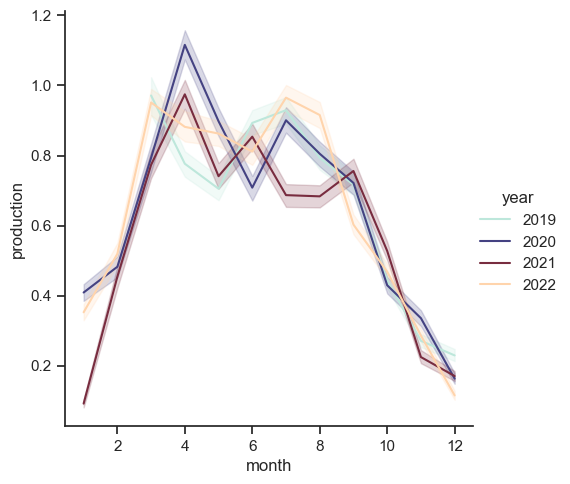

In [58]:
sns.relplot(
    data=data_from_csv,
    x="month", y="production",
    hue="year",
    kind="line", 
    height=5, aspect=1,
    palette = sns.color_palette("icefire", as_cmap=True)
)

<AxesSubplot:xlabel='hour'>

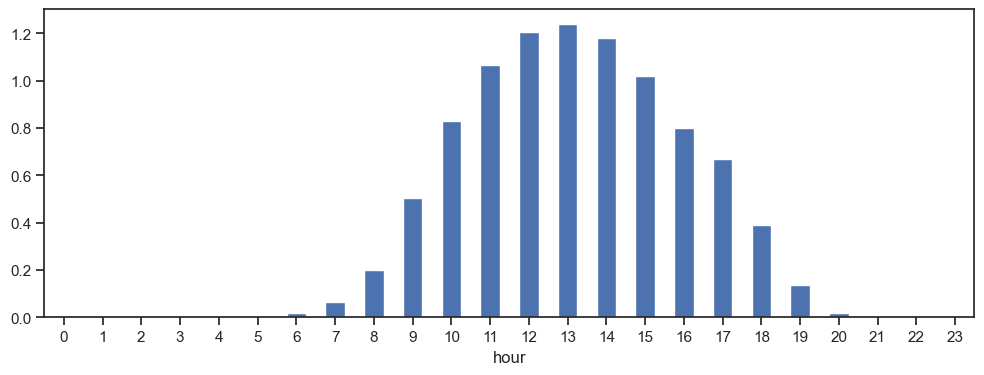

In [81]:
fig, axs = plt.subplots(figsize=(12, 4))
data_from_csv.groupby(data_from_csv["timestamp"].dt.hour)["production"].mean().plot(
    kind='bar', rot=0, ax=axs,
    xlabel = 'hour'
)

<AxesSubplot:xlabel='month'>

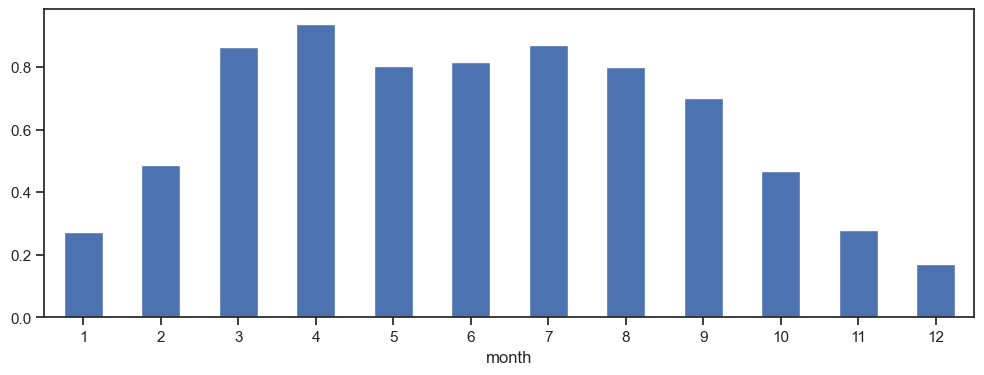

In [116]:
fig, axs = plt.subplots(figsize=(12, 4))
data_from_csv.groupby(data_from_csv["timestamp"].dt.month)["production"].mean().plot(
    kind='bar', rot=0, ax=axs,
    xlabel = 'month'
)

### <b style="color:blue;"> Split data for modelling and streaming </b>

In [4]:
SolarEdge_from_csv = pd.read_csv("SolarEdge_ProductionWSplit.csv")

In [16]:
start_date = '2019-07-01 00:00:00'
split_date = '2022-11-01 00:00:00'
end_date = '2022-11-30 23:59:59'

In [20]:
model_df = SolarEdge_from_csv
model_df = model_df.iloc[:,[0,3]].loc[model_df['timestamp'] < split_date]
model_df = model_df.loc[model_df['timestamp'] >= start_date]

stream_df = SolarEdge_from_csv
stream_df = stream_df.iloc[:,[0,3]].loc[stream_df['timestamp'] >= split_date]
stream_df = stream_df.loc[stream_df['timestamp'] < end_date]

In [24]:
model_df.to_csv("SolarEdge_data_for_modelling.csv", index=True)
stream_df.to_csv("SolarEdge_data_for_streaming.csv", index=True)